In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sc
from statsmodels.nonparametric.smoothers_lowess import lowess
import csaps
import rpy2.robjects as robj
from sklearn.metrics import mean_squared_error
import pywt
from skimage.restoration import denoise_wavelet

In [2]:
def RMSE(actual, predict):
    return np.sqrt(np.square(np.subtract(actual, predict)).mean())

data_nametag = "bigdata"
clean_string = "clean_" + data_nametag + ".csv"
noisy_string = "noisy_" + data_nametag + ".csv"
outliers_string = "outliers_" + data_nametag + ".csv"

clean_df = pd.read_csv(clean_string, index_col=0)
noisy_df = pd.read_csv(noisy_string, index_col=0)
outliers_df = pd.read_csv(outliers_string, index_col=0)

pdg_data = clean_df['Pressure(psi)'].to_numpy()
pdg_noisy = noisy_df['Pressure(psi)'].to_numpy()
pdg_outliers = outliers_df['Pressure(psi)'].to_numpy()
time_array = outliers_df['Time(s)'].to_numpy()

In [3]:
#LOWESS
lowess_outliers = lowess(pdg_outliers, time_array, frac=0.01)[:,1]
lowess_noisy = lowess(pdg_noisy, time_array, frac=0.01)[:,1]
#Polyfit
poly_outliers = np.poly1d(np.polyfit(time_array, pdg_outliers, 10))(time_array)
poly_noisy = np.poly1d(np.polyfit(time_array, pdg_noisy, 10))(time_array)
#Regression Splines
r_x = robj.FloatVector(time_array)
r_y_outliers = robj.FloatVector(pdg_outliers)
r_y_noisy = robj.FloatVector(pdg_noisy)
r_smooth_spline = robj.r['smooth.spline']
spl_outliers = np.asarray(r_smooth_spline(x=r_x, y=r_y_outliers, cv=True)[1])
spl_noisy = np.asarray(r_smooth_spline(x=r_x, y=r_y_noisy, cv=True)[1])
#Wavelet
wavelet_outliers = denoise_wavelet(pdg_outliers, wavelet='sym8', mode='soft', method='BayesShrink')
wavelet_noisy = denoise_wavelet(pdg_noisy, wavelet='sym8', mode='soft', method='BayesShrink')

In [4]:
df_lowess_outliers = pd.DataFrame(list(zip(time_array, lowess_outliers)), columns=['Time(s)', 'Pressure(psi)'])
df_lowess_noisy = pd.DataFrame(list(zip(time_array, lowess_noisy)), columns=['Time(s)', 'Pressure(psi)'])
df_lowess_outliers.to_csv("lowess_outliers_" + data_nametag + ".csv")
df_lowess_noisy.to_csv("lowess_noisy_" + data_nametag + ".csv")

df_poly_outliers = pd.DataFrame(list(zip(time_array, poly_outliers)), columns=['Time(s)', 'Pressure(psi)'])
df_poly_noisy = pd.DataFrame(list(zip(time_array, poly_noisy)), columns=['Time(s)', 'Pressure(psi)'])
df_poly_outliers.to_csv("poly_outliers_" + data_nametag + ".csv")
df_poly_noisy.to_csv("poly_noisy_" + data_nametag + ".csv")

df_spl_outliers = pd.DataFrame(list(zip(time_array, spl_outliers)), columns=['Time(s)', 'Pressure(psi)'])
df_spl_noisy = pd.DataFrame(list(zip(time_array, spl_noisy)), columns=['Time(s)', 'Pressure(psi)'])
df_spl_outliers.to_csv("spl_outliers_" + data_nametag + ".csv")
df_spl_noisy.to_csv("spl_noisy_" + data_nametag + ".csv")

df_wavelet_outliers = pd.DataFrame(list(zip(time_array, wavelet_outliers)), columns=['Time(s)', 'Pressure(psi)'])
df_wavelet_noisy = pd.DataFrame(list(zip(time_array, wavelet_noisy)), columns=['Time(s)', 'Pressure(psi)'])
df_wavelet_outliers.to_csv("wavelet_outliers_" + data_nametag + ".csv")
df_wavelet_noisy.to_csv("wavelet_noisy_" + data_nametag + ".csv")

In [5]:
rmse_lowess_outliers = RMSE(pdg_data, lowess_outliers)
rmse_lowess_noisy = RMSE(pdg_data, lowess_noisy)
rmse_poly_outliers = RMSE(pdg_data, poly_outliers)
rmse_poly_noisy = RMSE(pdg_data, poly_noisy)
rmse_spl_outliers = RMSE(pdg_data, spl_outliers)
rmse_spl_noisy = RMSE(pdg_data, spl_noisy)
rmse_wavelet_outliers = RMSE(pdg_data, wavelet_outliers)
rmse_wavelet_noisy = RMSE(pdg_data, wavelet_noisy)

label_lowess_outliers = 'LOWESS / Outliers - RMSE=' + str(round(rmse_lowess_outliers, 3))
label_lowess_noisy = 'LOWESS / Noisy - RMSE=' + str(round(rmse_lowess_noisy, 3))
label_poly_outliers = 'Polyfit / Outliers - RMSE=' + str(round(rmse_poly_outliers, 3))
label_poly_noisy = 'Polyfit / Noisy - RMSE=' + str(round(rmse_poly_noisy, 3))
label_spl_outliers = 'Spline / Outliers - RMSE=' + str(round(rmse_spl_outliers, 3))
label_spl_noisy = 'Spline / Noisy - RMSE=' + str(round(rmse_spl_noisy, 3))
label_wavelet_outliers = 'Wavelet / Outliers - RMSE=' + str(round(rmse_wavelet_outliers, 3))
label_wavelet_noisy = 'Wavelet / Noisy - RMSE=' + str(round(rmse_wavelet_noisy, 3))

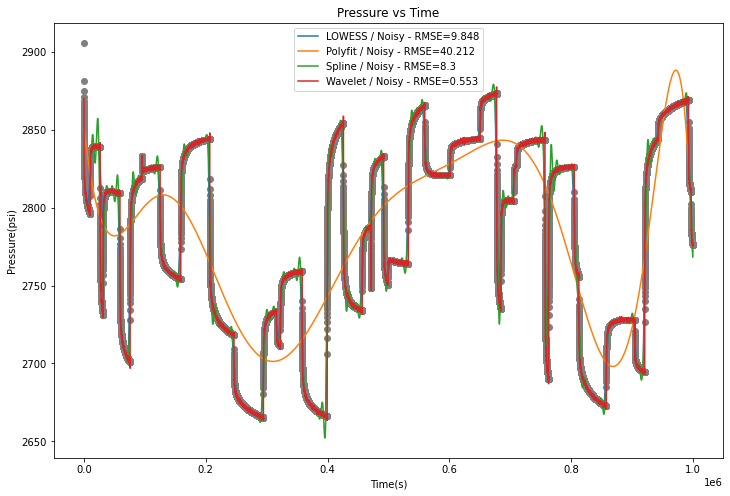

In [6]:
plt.figure(figsize=(12,8))
plt.scatter(time_array, pdg_data, color='grey')
plt.plot(time_array, lowess_noisy, label=label_lowess_noisy)
plt.plot(time_array, poly_noisy, label=label_poly_noisy)
plt.plot(time_array, spl_noisy, label=label_spl_noisy)
plt.plot(time_array, wavelet_noisy, label=label_wavelet_noisy)
plt.title("Pressure vs Time")
plt.xlabel("Time(s)")
plt.ylabel("Pressure(psi)")
plt.legend()
plt.savefig("methods_noisy_" + data_nametag, dpi=400)

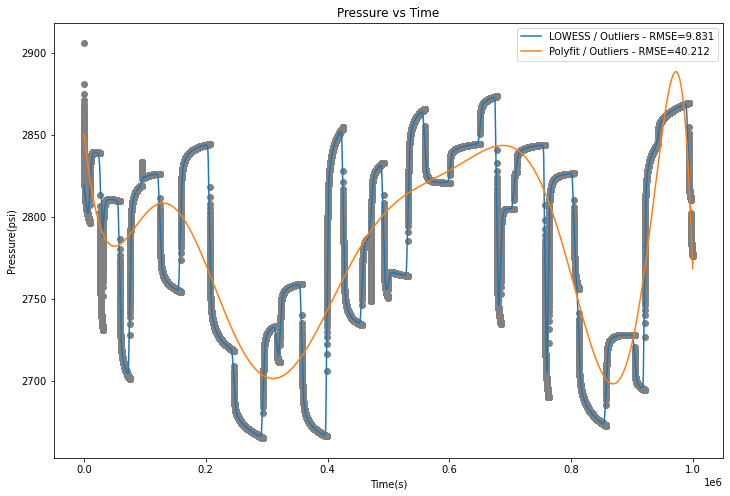

In [8]:
plt.figure(figsize=(12,8))
plt.scatter(time_array, pdg_data, color='grey')
plt.plot(time_array, lowess_outliers, label=label_lowess_outliers)
plt.plot(time_array, poly_outliers, label=label_poly_outliers)
#plt.plot(time_array, spl_outliers, label=label_spl_outliers)
plt.title("Pressure vs Time")
plt.xlabel("Time(s)")
plt.ylabel("Pressure(psi)")
plt.legend()
#plt.savefig("methods_outliers_" + data_nametag, dpi=400)